In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Código para extrar un archivo zip.

In [ ]:
#import zipfile
#import os

# Ruta al archivo ZIP
#path_to_images = '/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba.zip'
# Directorio de salida para las imágenes descomprimidas
#output_directory = '/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/'

# Descomprimir el archivo ZIP
#with zipfile.ZipFile(path_to_images, 'r') as zip_ref:
    #zip_ref.extractall(output_directory)

# Verificar que se hayan descomprimido correctamente
#extracted_files = os.listdir(output_directory)

#Visualizar imágenes.

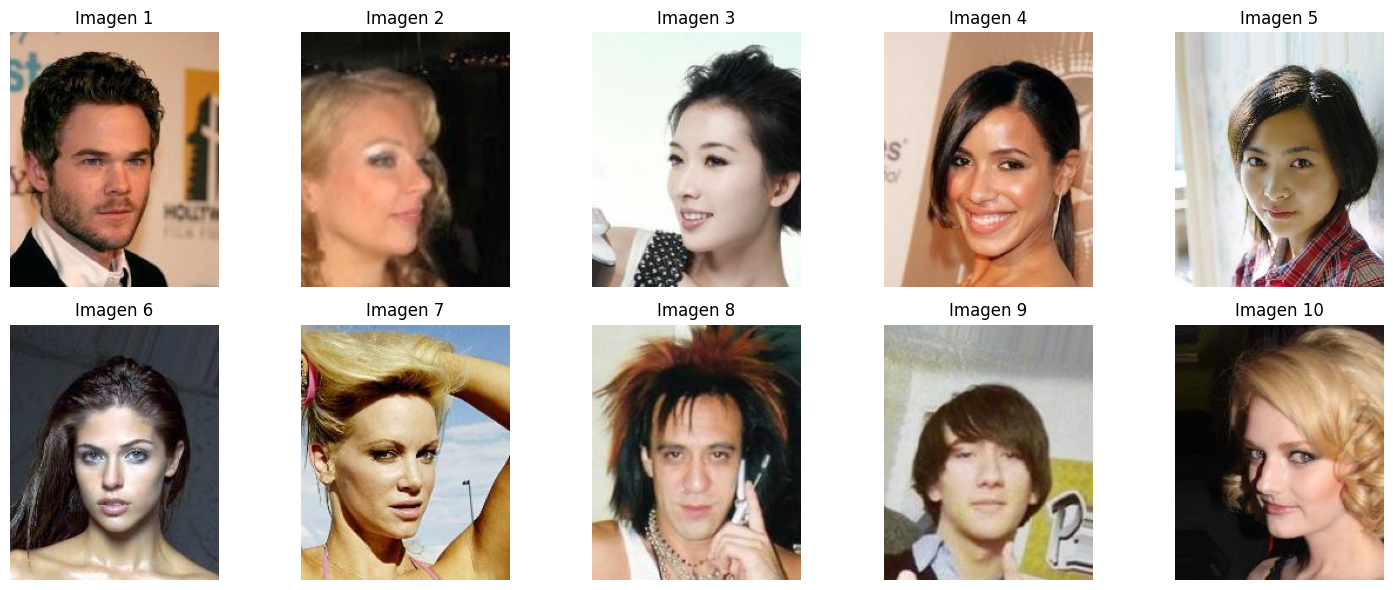

In [19]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directorio que contiene las imágenes
path_to_images = '/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba'

# Lista de nombres de archivo de las imágenes
image_files = os.listdir(path_to_images)

# Configuración del diseño de las subgráficas
num_rows = 2
num_cols = 5
total_images = num_rows * num_cols

# Crear una figura y ejes para las subgráficas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Iterar sobre las subgráficas y mostrar las imágenes
for i, ax in enumerate(axes.flat):
    # Nombre del archivo de la imagen
    image_file = image_files[i]

    # Ruta completa de la imagen
    image_path = os.path.join(path_to_images, image_file)

    # Cargar la imagen
    image = Image.open(image_path)

    # Mostrar la imagen en el eje actual
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Imagen {i+1}')

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar las subgráficas
plt.show()



#Preprocesamiento de la base de datos.

In [20]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', sep=' ', header = None)

# Eliminar el dobel espacio entre algunos datos de la tabla
with open('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', 'r') as f:
    print("skipping : " + f.readline())
    print("skipping headers : " + f.readline())
    with open('attr_celeba_prepared.txt' , 'w') as newf:
        for line in f:
            new_line = ' '.join(line.split())
            newf.write(new_line)
            newf.write('\n')



print("-----------")
print(df[0].head())
print(df.iloc[:,1:].head())
print("----------")

files = tf.data.Dataset.from_tensor_slices(df[0])
attributes = tf.data.Dataset.from_tensor_slices(df.iloc[:,1:].to_numpy())
data = tf.data.Dataset.zip((files, attributes))
print(data)

path_to_images = '/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba/'
def process_file(file_name, attributes):
    image = tf.io.read_file(path_to_images + file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  #
    return image, attributes

labeled_images = data.map(process_file)

print(labeled_images)


exit()



skipping : 0

skipping headers : 202599

-----------
0                                                    0
1                                               202599
2    5_o_Clock_Shadow Arched_Eyebrows Attractive Ba...
3    000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1...
4    000002.jpg -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1 -1...
Name: 0, dtype: object
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
----------
<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(0,), dtype=tf.float64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(0,), dtype=tf.float64, name=None))>


#Entrenar red neuronal

In [7]:
# Crear listas para almacenar las imágenes y las etiquetas
X = []
y = []

# Recorrer el conjunto de datos labeled_images y extraer las imágenes y las etiquetas
for image, attributes in labeled_images:
    # Agregar la imagen a la lista X
    X.append(image.numpy())
    # Agregar las etiquetas a la lista y
    y.append(attributes.numpy())

# Convertir las listas a arrays numpy
X = np.array(X)
y = np.array(y)

# Verificar las formas de los arrays X e y
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)



NameError: name 'labeled_images' is not defined

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Cargar el modelo VGG16 pre-entrenado en ImageNet, sin incluir las capas densas (clasificador)
base_model = VGG16(weights='imagenet', include_top=False)

# Congelar los pesos de las capas convolucionales del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas densas para la clasificación de los atributos de CelebA
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convertir los mapas de características en un vector unidimensional
x = Dense(512, activation='relu')(x)
predictions = Dense(40, activation='sigmoid')(x)  # 40 nodos de salida para los atributos de CelebA

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con los datos de CelebA
# (Aquí debes reemplazar X_train y y_train con tus datos de entrenamiento)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Añadir nuevas capas densas para la clasificación de rostros o no rostros
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convertir los mapas de características en un vector unidimensional
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Una neurona de salida para clasificación binaria (rostro o no rostro)

# Definir el modelo final para la clasificación de rostros o no rostros
face_model = Model(inputs=base_model.input, outputs=predictions)

# Congelar los pesos de las capas convolucionales del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo para la clasificación de rostros o no rostros
face_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Entrenar el modelo con los datos para clasificar rostros o no rostros
# (Aquí debes reemplazar X_train_faces y y_train_faces con tus datos de entrenamiento para rostros)
history_face = face_model.fit(X_train_faces, y_train_faces, epochs=10, validation_data=(X_test_faces, y_test_faces))



58889256/58889256 [==============================] - 1s 0us/step


NameError: name 'X_train' is not defined

In [8]:
import tensorflow as tf
import pandas as pd

# Cargar los datos
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', sep=' ', header=None)

# Eliminar el doble espacio entre algunos datos de la tabla
with open('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', 'r') as f:
    print("skipping : " + f.readline())
    print("skipping headers : " + f.readline())
    with open('attr_celeba_prepared.txt', 'w') as newf:
        for line in f:
            new_line = ' '.join(line.split())
            newf.write(new_line)
            newf.write('\n')

# Preparar los datos
files = df[0].values
attributes = df.iloc[:, 1:].values

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(files))
train_files, test_files = files[:train_size], files[train_size:]
train_attributes, test_attributes = attributes[:train_size], attributes[train_size:]

# Definir la función para procesar las imágenes
path_to_images = '/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba/'

def process_file(file_name, attributes):
    image = tf.io.read_file(path_to_images + file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0
    return image, attributes

# Crear conjuntos de datos utilizando TensorFlow Dataset API
train_data = tf.data.Dataset.from_tensor_slices((train_files, train_attributes))
train_data = train_data.map(process_file)

test_data = tf.data.Dataset.from_tensor_slices((test_files, test_attributes))
test_data = test_data.map(process_file)

# Definir la arquitectura del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(40, activation='sigmoid')  # 40 atributos de salida
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_data.batch(32), epochs=10, validation_data=test_data.batch(32))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_data.batch(32))
print('Test accuracy:', test_acc)


skipping : 0

skipping headers : 202599

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 40) vs (None, 0)).


In [9]:
import tensorflow as tf
import pandas as pd

# Carga de datos
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', sep=' ', header=None)
files = tf.data.Dataset.from_tensor_slices(df[0])
attributes = tf.data.Dataset.from_tensor_slices(df.iloc[:, 1:].to_numpy())
data = tf.data.Dataset.zip((files, attributes))

# Definición del modelo
model = tf.keras.Sequential([
    # Capas convolucionales, etc.
    # Asegúrate de que la última capa tenga 40 unidades para predecir los atributos
    tf.keras.layers.Dense(40, activation='sigmoid')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(data.batch(32), epochs=10)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "dense_6" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None


In [10]:
import tensorflow as tf
import pandas as pd

# Cargar el dataframe
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', sep=' ', header=None)

# Cargar las imágenes
images = "/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba/"  # Carga las imágenes desde tu Google Drive

# Preprocesar los datos según sea necesario

# Definir la arquitectura del modelo
inputs_img = tf.keras.layers.Input(shape=(altura, anchura, canales))
# Definir capas convolucionales, de pooling, etc. para procesar las imágenes

inputs_df = tf.keras.layers.Input(shape=(num_features,))
# Definir capas densas u otras capas para procesar los datos del dataframe

# Fusionar las salidas de ambas ramas del modelo
merged = tf.keras.layers.concatenate([salida_img, salida_df])

# Agregar capas adicionales para la salida final
# Esto puede ser una capa densa seguida de una capa de salida con la función de activación adecuada

# Crear el modelo
model = tf.keras.models.Model(inputs=[inputs_img, inputs_df], outputs=outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit([images, df], labels, epochs=10, validation_split=0.2)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate([images_test, df_test], labels_test)


NameError: name 'altura' is not defined

In [16]:
import tensorflow as tf
import pandas as pd

# Cargar el dataframe
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', sep=' ', header=None)

# Cargar las imágenes
images = "/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba/"  # Carga las imágenes desde tu Google Drive

# Preprocesar los datos según sea necesario

# Definir la arquitectura del modelo para procesar las imágenes
inputs_img = tf.keras.layers.Input(shape=(altura, anchura, canales))
# Definir capas convolucionales, de pooling, etc. para procesar las imágenes

# Definir la salida de la rama de procesamiento de imágenes
salida_img = capa_final_img  # Reemplaza "capa_final_img" con la capa final de tu rama de procesamiento de imágenes

# Definir la arquitectura del modelo para procesar el dataframe
inputs_df = tf.keras.layers.Input(shape=(num_features,))
# Definir capas densas u otras capas para procesar los datos del dataframe

# Fusionar las salidas de ambas ramas del modelo
merged = tf.keras.layers.concatenate([salida_img, salida_df])

# Agregar capas adicionales para la salida final
# Esto puede ser una capa densa seguida de una capa de salida con la función de activación adecuada

# Crear el modelo
model = tf.keras.models.Model(inputs=[inputs_img, inputs_df], outputs=outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Verificar la forma de las etiquetas en el conjunto de datos de prueba
for images, labels in test_data:
    print(labels.shape)

# Entrenar el modelo
history = model.fit(train_data, epochs=10, validation_data=test_data)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(test_data)


NameError: name 'salida_df' is not defined

In [17]:
import pandas as pd
import numpy as np
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Cargar el dataframe
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Tarea 8/attr_celeba_prepared.txt', sep=' ', header=None)

# Preprocesar el dataframe
# Por ejemplo, puedes eliminar filas o columnas innecesarias, cambiar el formato de los datos, etc.

# Cargar las imágenes y preprocesarlas
images_dir = "/content/drive/MyDrive/Redes Neuronales/Tarea 8/CelebA/img_align_celeba/"
images = []
for filename in df[0]:
    image_path = os.path.join(images_dir, filename)
    # Leer la imagen
    image = cv2.imread(image_path)
    # Redimensionar la imagen a un tamaño fijo (por ejemplo, 224x224)
    image = cv2.resize(image, (224, 224))
    # Normalizar los valores de píxeles a un rango de 0 a 1
    image = image / 255.0
    images.append(image)

# Convertir la lista de imágenes a un array numpy
images_array = np.array(images)

# Preprocesar las etiquetas del dataframe
labels = df.iloc[:, 1:].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images_array, labels, test_size=0.2, random_state=42)

# Definir la arquitectura del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(40, activation='sigmoid')  # 40 nodos de salida para los 40 atributos
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Precisión del modelo en el conjunto de prueba:", test_acc)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


#Nuevo intento sin usar recomendaciones

#Detectar rostros

##Librerias

In [33]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

##Preprocesamiento

In [34]:
# Cargar la base de datos LFW con un tamaño mínimo de rostros por persona de 70 y una escala de grises de 0-255
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, color=False)

# Obtener las imágenes y las etiquetas de la base de datos
imagenes = lfw_dataset.images
etiquetas = lfw_dataset.target
nombres_etiquetas = lfw_dataset.target_names

# Normalizar los valores de píxeles a un rango de 0 a 1
imagenes = imagenes / 255.0

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que tengan la forma (altura, anchura, canales)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convertir las etiquetas a variables categóricas
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Contrucción de red neuronal

Epoch 1/10
33/33 [==============================] - 10s 157ms/step - loss: 1.7648 - accuracy: 0.3922 - val_loss: 1.6014 - val_accuracy: 0.4612
Epoch 2/10
33/33 [==============================] - 3s 105ms/step - loss: 1.7089 - accuracy: 0.3990 - val_loss: 1.6004 - val_accuracy: 0.4612
Epoch 3/10
33/33 [==============================] - 4s 126ms/step - loss: 1.7065 - accuracy: 0.3990 - val_loss: 1.5939 - val_accuracy: 0.4612
Epoch 4/10
33/33 [==============================] - 6s 176ms/step - loss: 1.7176 - accuracy: 0.3990 - val_loss: 1.6204 - val_accuracy: 0.4612
Epoch 5/10
33/33 [==============================] - 4s 107ms/step - loss: 1.7103 - accuracy: 0.3990 - val_loss: 1.5966 - val_accuracy: 0.4612
Epoch 6/10
33/33 [==============================] - 4s 110ms/step - loss: 1.7092 - accuracy: 0.3990 - val_loss: 1.5988 - val_accuracy: 0.4612
Epoch 7/10
33/33 [==============================] - 4s 131ms/step - loss: 1.7071 - accuracy: 0.3990 - val_loss: 1.6186 - val_accuracy: 0.4612
Epoch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


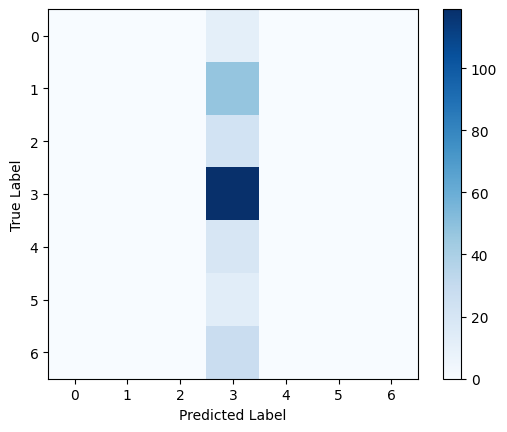

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
from keras.models import load_model

# Definir el modelo de red neuronal convolucional (CNN)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(nombres_etiquetas), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Predecir las etiquetas para los datos de prueba
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Mostrar el reporte de clasificación y la matriz de confusión
print(classification_report(np.argmax(y_test, axis=1), y_pred_labels, target_names=nombres_etiquetas))
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
plt.imshow(conf_mat, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Guardar el modelo entrenado en un archivo
model.save('modelo_reconocimiento_facial.h5')

# Cargar el modelo desde el archivo guardado
modelo_cargado = load_model('modelo_reconocimiento_facial.h5')


#Transfer-Learning

##Visualización de datos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


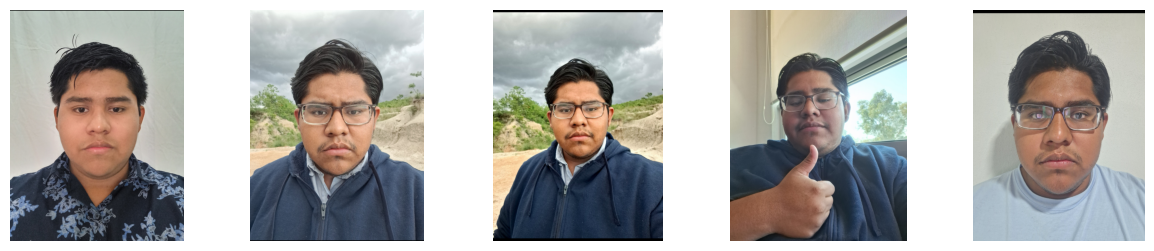

In [36]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Directorio que contiene las imágenes
data_dir = '/content/drive/MyDrive/José Miguel/'

# Obtener una lista de nombres de archivos en el directorio
file_list = os.listdir(data_dir)

# Seleccionar las primeras 5 imágenes
images_to_show = file_list[:5]

# Configurar el subplot
plt.figure(figsize=(15, 3))

# Mostrar las 5 imágenes en 5 columnas
for i, image_name in enumerate(images_to_show, 1):
    # Ruta completa de la imagen
    image_path = os.path.join(data_dir, image_name)
    # Leer la imagen
    image = cv2.imread(image_path)
    # Convertir la imagen de BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Añadir la imagen al subplot
    plt.subplot(1, 5, i)
    plt.imshow(image_rgb)
    plt.axis('off')  # No mostrar ejes

# Mostrar el conjunto de imágenes
plt.show()


##Preprocesamos mis imagenes y aumento de datos

In [45]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Ruta al directorio que contiene las imágenes
data_dir = '/content/drive/MyDrive/José Miguel/'

# Crear una lista para almacenar las imágenes preprocesadas y las etiquetas
images = []
labels = []

# Tamaño común para todas las imágenes
target_size = (47, 62)

# Función para cargar las imágenes y aplicar aumento de datos
def augment_images(data_dir):
    # Crear un generador de datos para aumentar las imágenes
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Iterar sobre todas las imágenes en la carpeta
    for image_name in os.listdir(data_dir):
        image_path = os.path.join(data_dir, image_name)
        # Leer la imagen y redimensionarla al tamaño deseado
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        # Aplicar aumento de datos a la imagen
        image = np.expand_dims(image, axis=0)  # Añadir una dimensión adicional para que coincida con el formato del generador
        for X_batch in datagen.flow(image, batch_size=1):
            # Remover la dimensión adicional agregada durante el aumento de datos
            X_batch = np.squeeze(X_batch, axis=0)
            # Agregar la imagen aumentada a la lista
            images.append(X_batch)
            # Agregar la etiqueta "Miguel" a la lista de etiquetas
            labels.append("Miguel")
            break  # Salir después de generar una imagen aumentada

# Llamar a la función para cargar las imágenes y aplicar aumento de datos
augment_images(data_dir)

# Convertir las listas a matrices numpy
images = np.array(images)
labels = np.array(labels)

# Verificar las formas de las matrices
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)


Shape of images array: (46, 62, 47, 3)
Shape of labels array: (46,)


In [46]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos de datos
print("Shape of training images:", X_train.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of test images:", X_test.shape)
print("Shape of test labels:", y_test.shape)


Shape of training images: (36, 62, 47, 3)
Shape of training labels: (36,)
Shape of test images: (10, 62, 47, 3)
Shape of test labels: (10,)


In [49]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# Cargar el modelo preentrenado
modelo_reconocimiento_facial = load_model('modelo_reconocimiento_facial.h5')

# Definir un nuevo modelo para el transfer learning
modelo_transfer_learning = Sequential([
    modelo_reconocimiento_facial.layers[0],  # Capa de entrada del modelo preentrenado
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Dos clases: Miguel y No Miguel
])

# Compilar el modelo
modelo_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Redimensionar y convertir las imágenes a escala de grises
X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_train_resized])
X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_test_resized])

# Expandir las dimensiones de las imágenes para que tengan el formato adecuado
X_train_gray = np.expand_dims(X_train_gray, axis=-1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)

# Convertir las etiquetas a formato one-hot
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Entrenar el modelo transfer learning
history_transfer = modelo_transfer_learning.fit(X_train_gray, y_train_encoded, epochs=10, validation_data=(X_test_gray, y_test_encoded))



ValueError: invalid literal for int() with base 10: 'Miguel'